# Using Featuristic With scikit-learn Pipelines

Featuristic is fully compatible with scikit-learn's `Pipeline` class, which can be used to sequentially apply a list of transformers to process your data.

Let's take a look at an example using the `cars` dataset.



In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

0.1.1


### Load the Data

In [2]:
X, y = ft.fetch_cars_dataset()

X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [3]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

### Objective Function

We use a custom objective function to pass into the Genetic Feature Selection algorithm. The output of this will be minimized to find the optimal subset of features.

In [4]:
def objective(X, y):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return -scores.mean()

### Fit a scikit-learn Pipeline Containing Featuristic

In [5]:
pipe = Pipeline(
    steps=[
        (
            "genetic_feature_synthesis",
            ft.GeneticFeatureSynthesis(
                num_features=10,
                population_size=100,
                max_generations=50,
                early_termination_iters=15,
                n_jobs=-1,
            ),
        ),
        (
            "genetic_feature_selector",
            ft.GeneticFeatureSelector(
                objective_function=objective,
                population_size=100,
                crossover_proba=0.75,
                max_generations=50,
                early_termination_iters=25,
                n_jobs=-1,
            ),
        ),
    ]
)

features = pipe.fit_transform(X, y)

Optimising feature selection...:  82%|███████████████████████████████████████████████████████████████▉              | 41/50 [00:04<00:00, 10.24it/s]


In [6]:
features.head()

,cylinders,weight,feature_2,feature_5,feature_8
0,8,3504,-2.412136e+08,-2.412136e+08,-2.412139e+08
1,8,3693,-1.905969e+08,-1.905969e+08,-1.905972e+08
2,8,3436,-2.405944e+08,-2.405944e+08,-2.405946e+08
3,8,3433,-2.520235e+08,-2.520235e+08,-2.520237e+08
4,8,3449,-2.518106e+08,-2.518106e+08,-2.518108e+08


## Accessing Featuristic Inside the Pipeline

We can still access the individual Featuristic steps via the pipeline's `named_steps` functionality. For example, to look at the formulas used for the feature engineering or to plot the genetic algorithm's history.

In [7]:
gfs = pipe.named_steps["genetic_feature_synthesis"]

gfs.get_feature_info().head()

,name,formula,fitness
0,feature_2,(((((square((horsepower / model_year)) + cube(...,-0.905968
1,feature_5,(((((sin(((horsepower + cube(horsepower)) - si...,-0.905802
2,feature_0,(((((acceleration + cube(-(-(weight)))) + squa...,-0.906063
3,feature_3,((((((acceleration + cube(-(-(weight)))) + squ...,-0.905881
4,feature_6,(((((((acceleration + cube(-(-(weight)))) + sq...,-0.905730


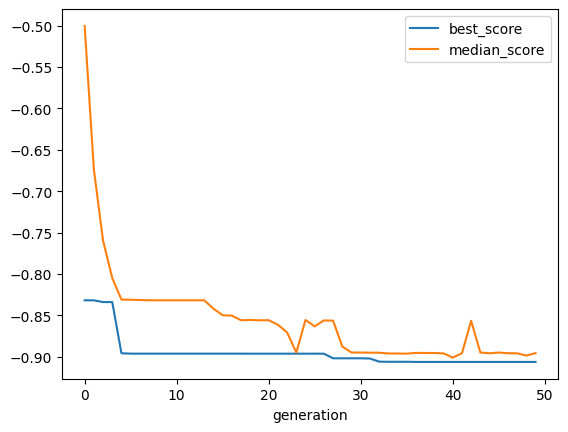

In [8]:
gfs.plot_history()